In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install keras_unet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import keras_unet.utils as kutils
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (14, 7)

In [4]:
import cv2 
from pathlib import Path
from typing import List

DATA_DIR = "data"
GOLD_STANDARD_DIR = "manual1" 
FOV_DIR = "mask" 
IMAGE_DIR = "images"

def load_image(sample_name: str):
    sample_dir = Path(DATA_DIR) / Path(IMAGE_DIR)

    for ext in [ '.jpg', '.JPG' ]:
        sample = sample_dir / Path(sample_name + ext)
        if sample.is_file:
            return plt.imread(str(sample))

    raise FileNotFoundError

def load_fov(sample_name: str):
    sample_dir = Path(DATA_DIR) / Path(FOV_DIR)

    sample = sample_dir / Path(sample_name + '_mask.tif')
    if not sample.is_file:
        raise FileNotFoundError

    return cv2.imread(str(sample), cv2.IMREAD_GRAYSCALE)

def load_gold_standard(sample_name: str):
    sample_dir = Path(DATA_DIR) / Path(GOLD_STANDARD_DIR)

    sample = sample_dir / Path(sample_name + '.tif')
    if not sample.is_file:
        raise FileNotFoundError

    # load image in grayscale
    return cv2.imread(str(sample), cv2.IMREAD_GRAYSCALE)
  
def get_all_sample_names() -> List[str]:
    """ Return list of strings - names of given samples. We can get from names to images, fovs, and gold_standards """
    
    # Use files from Gold Standards, because they have basic names + tif extension
    samples_dir = Path(DATA_DIR) / Path(GOLD_STANDARD_DIR)

    # data/manual1/01_dr.tif -> 01_dr
    sample_names = [ sample_file.stem for sample_file in samples_dir.iterdir() ] 
    return sample_names

In [6]:
PATCH_SIZE = 256
PATCH_STRIDE = 128

def get_batch_names(sample_names, num_batches):
    return np.array_split(sample_names, num_batches)

def get_batch_data(sample_names, val_sample_names, patch_size=PATCH_SIZE, patch_stride=PATCH_STRIDE):
    x_train = kutils.get_patches(
        np.array([load_image(path) for path in sample_names], dtype=np.float32),
        size=patch_size,
        stride=patch_stride
    )
    y_train = kutils.get_patches(
        np.expand_dims(np.array([load_gold_standard(path) for path in sample_names], dtype=np.float32), -1),
        size=patch_size,
        stride=patch_stride
    )
    x_val = kutils.get_patches(
        np.array([load_image(path) for path in val_sample_names], dtype=np.float32),
        size=patch_size,
        stride=patch_stride
    )
    y_val = kutils.get_patches(
        np.expand_dims(np.array([load_gold_standard(path) for path in val_sample_names], dtype=np.float32), -1),
        size=patch_size,
        stride=patch_stride
    )

    x_train /= 255
    y_train /= 255
    x_val /= 255
    y_val /= 255
    
    return x_train, y_train, x_val, y_val

x_train = kutils.get_patches(
    np.array([load_image(path) for path in ['01_dr']]),
    size=PATCH_SIZE,
    stride=PATCH_STRIDE
)

In [6]:
# from sklearn.model_selection import train_test_split

# x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=0)

# x_len = x_train.shape[0] + x_val.shape[0]

# train_data = kutils.get_augmented(x_train, y_train)

In [7]:
from keras_unet.models import custom_unet
from keras_unet.metrics import iou, iou_thresholded
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.optimizers import SGD
import os

model = custom_unet(input_shape=x_train[0].shape)

checkpoint_callback = ModelCheckpoint(
    'fundus_segm_v1.h5',
    monitor='val_loss',
    save_best_only=True
)

if os.path.exists("model_history_log.csv"):
    os.remove("model_history_log.csv")

csv_logger = CSVLogger("model_history_log.csv", append=True)

model.compile(
    SGD(learning_rate=0.01),
    "binary_crossentropy",
    metrics=[iou]
)

In [8]:
# model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  432         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [14]:
import gc

batch_size = 16

sample_names = list(filter(lambda x: '0' in x and '9' not in x, get_all_sample_names()))
val_sample_names = list(filter(lambda x: '09' in x, get_all_sample_names()))

for i in range(4):
    print('real epoch', i, 'starts here.')
    for batch_names in get_batch_names(sample_names, 9):
        gc.collect()
        
        x_train, y_train, x_val, y_val = get_batch_data(batch_names, val_sample_names)

        # train_data = kutils.get_augmented(x_train, y_train)

        # model.fit_generator(
        #     train_data,
        #     steps_per_epoch=2,
        #     epochs = 1,
        #     validation_data=(x_val, y_val),
        #     callbacks=[checkpoint_callback, csv_logger]
        # )

        model.fit(
            x_train,
            y_train,
            batch_size = 64,
            epochs = 1,
            validation_data=(x_val, y_val),
            callbacks=[checkpoint_callback, csv_logger]
        )

        del x_train
        del y_train
        del x_val
        del y_val

model.save('fundus_segm_v1_final.h5')

real epoch 0 starts here.
14/14 [==============================] - 16s 1s/step - loss: 0.0913 - iou: 0.5518 - val_loss: 0.0737 - val_iou: 0.5432
real epoch 1 starts here.
14/14 [==============================] - 16s 1s/step - loss: 0.1192 - iou: 0.4959 - val_loss: 0.0797 - val_iou: 0.5390


KeyboardInterrupt: ignored

# Test

(1, 2336, 3504, 3)
3/3 [==============================] - 9s 3s/step
(81, 256, 256, 3) (81, 256, 256, 1)
9 9


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


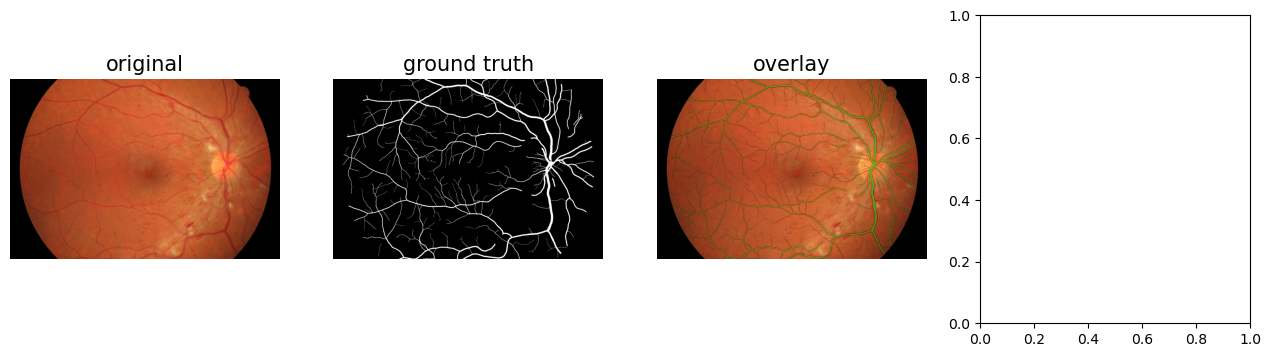

In [14]:
import keras
from keras_unet.metrics import iou

test_sample_names = ['15_dr'] #list(filter(lambda x: '0' not in x, get_all_sample_names()))

model = keras.models.load_model('fundus_segm_v1.h5', custom_objects={'iou': iou})

xx = np.array([load_image(path) for path in test_sample_names], dtype=np.float32)
x_test = kutils.get_patches(
    xx,
    size=PATCH_SIZE,
    stride=PATCH_SIZE
)

yy = np.expand_dims(np.array([load_gold_standard(path) for path in test_sample_names], dtype=np.float32), -1)
y_test = kutils.get_patches(
    yy,
    size=PATCH_SIZE,
    stride=PATCH_SIZE
)

print(xx.shape)

y_pred = model.predict(x_test)

print(x_test.shape, y_pred.shape)

# kutils.plot_patches(
#     img_arr=y_pred, # required - array of cropped out images
#     org_img_size=(y_pred.shape[1] * y_pred.shape[0], y_pred.shape[2] * y_pred.shape[0]), # required - original size of the image
#     stride=PATCH_STRIDE)

# pp = kutils.reconstruct_from_patches(
#     np.array([y_pred]),
#     org_img_size=(y_pred.shape[1] * y_pred.shape[0], y_pred.shape[2] * y_pred.shape[0]),
#     stride=None
# )

org_img_size = xx.shape[1:3]

pp = np.zeros(org_img_size)

size = PATCH_SIZE
stride = PATCH_SIZE

# i_max = (org_img_size[0] // stride) + 1 - (size // stride)
# j_max = (org_img_size[1] // stride) + 1 - (size // stride)

i_max = int(y_pred.shape[0] ** 0.5)
j_max = y_pred.shape[0] // i_max

print(i_max, j_max)

kk = 0
for i in range(i_max):
    for j in range(j_max):
        pp[
            i * stride : i * stride + size,
            j * stride : j * stride + size
        ] = y_pred[kk, :, :, 0]

        kk += 1

kutils.plot_imgs(xx / 255, yy, pp / 255, color="green")